# **Introduction to Image Processing**

** Dear students this is your first assignment in Image processing course, in the context of this assignment you have to:**
* **complete `2-enhancement.ipynb` up to section 2.7**
* **complete this notebook `2-enhancement-supplementary.ipynb`**
* **add your changes, commit and push your completed assignment to your github repo**

`2-enhancement-supplememtary.ipynb` provides more information on section 2.7

## 2.7 Your own implementation 

### Q.1 Import the required libraries and functions

In [4]:
% matplotlib inline
% pprint off
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
from skimage import exposure, io, img_as_ubyte

### import the libraries you think its necessary for your task 

Pretty printing has been turned ON


### Q.2 Contrast streching 

** Define your function which stretch the image contrast, `cont_str`, using minimum and maximum values from the image **

**This function should accept the input image, calculates the minimum and maximum and rescales the intensities.**

** Return the image as uint8 **

In [5]:
#Define a function that computes the minimum and maximum values and uses the function rescale intensity
#to stretch the contrast
def cont_str(image):
    #Find the smallest and largest values of the image
    smallest = np.amin(image)
    biggest = np.amax(image)
    #Perform the contrast stretching function on the image as given in the notes
    image = 255. * (image-smallest) / (biggest-smallest)
    #Export the image in ubyte format
    return image.astype('ubyte')

**Use your function to transform the  gray version of `satellite.jpg` image (ubyte format), show the original image and the transformed image and their histogram**

/Users/briannaburton/miniconda3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


Text(0.5,1,'Stretched Image Histogram')

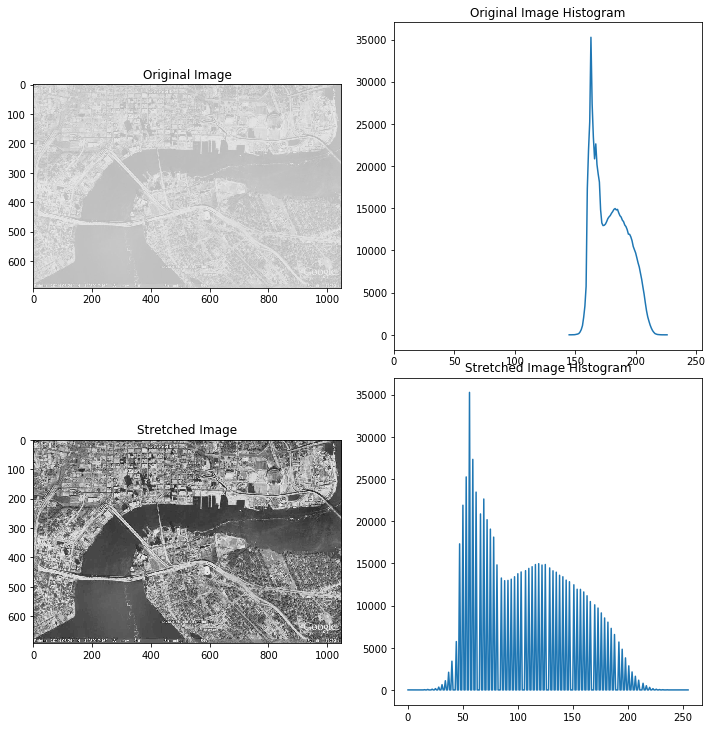

In [6]:
#Import satellite image as greyscale image and compute the histogram of the original image
img_path = './images/'
img_name = 'satellite.jpg'
satellite_im = io.imread(img_path.__add__(img_name), as_grey = True)
#This function reads the image as_grey which converts the image to float. Therefore, I turn it back into a ubyte image
#I am not sure if it is better to import and convert to black and white image, by going from integer to float to
#integer or just import and carry out the functions on the color image. Hence the error at the end of this question
satellite_im = img_as_ubyte(satellite_im)

satellite_im_hist = exposure.histogram(satellite_im)

#Apply the function cont_str to the satellite image to obtain a new image with stretched contrast
satellite_im_stretched = cont_str(satellite_im)
hist_satellite_im_stretched = exposure.histogram(satellite_im_stretched)

#Plot the original image, its histogram, the new image, and the new histogram
fig = plt.figure(figsize=(10, 10))

plt.subplot(221)
io.imshow(satellite_im, cmap = cm.Greys_r)
plt.title("Original Image")

plt.subplot(222)
plt.plot(satellite_im_hist[1], satellite_im_hist[0])
plt.xlim((0,255))
plt.title("Original Image Histogram")

plt.subplot(223)
io.imshow(satellite_im_stretched,cmap = cm.Greys_r)
plt.title("Stretched Image")

plt.subplot(224)
plt.plot(hist_satellite_im_stretched[1], hist_satellite_im_stretched[0])
plt.title("Stretched Image Histogram")

### Q.3 Histogram equalization
Histogram equalization can be used to enhance the contrast in images.

The idea behind the histogram equalization process is that each gray level should have an equal contribution in the image. The function allowing such transformation is in fact the cumulative density function.

**Define your own histgram equalization function, `hist_eq`**

**This function should accpet the image, max_int and min_int and return the transformed image and its cdf**

In [7]:
def hist_eq(image, min_int, max_int):
    
    #Compute the histogram for the image and save the values into 
    #hist for the intensity frequencies and values for the pixel intensities
    #Initially, I tried to use exposure.histogram, but it was impossible: it would
    #give an error by defining the histogram to only 82 values, which doesn't make 
    #sense for this image.
    hist, bins = np.histogram(image.flatten(),256,[0,255])
    #Sum all the values in the histogram to normalize it
    norm_hist = hist / sum(hist)
    #Find the cumulative histogram/cumulative density function
    cdf = np.cumsum(norm_hist)
    #Use the transform function given in the notes to compute the
    #equalized image
    tf = cdf*(max_int - min_int)
    new_image = np.zeros_like(image)
    for x in range (0,691):
        for y in range (0,1048):
            new_image[x,y] = tf[image[x,y]]
    new_hist = exposure.histogram(new_image)
    new_norm_hist = new_hist / sum(new_hist)
    new_cdf = np.cumsum(new_norm_hist)
    return new_image.astype('ubyte'), new_cdf


** Use your function to transform the gray version of `satellite.jpg` image again in ubyte format**

** max_int = 255, min_int = 0 **

In [8]:
#Apply the function cont_str to the satellite image to obtain a new image with histogram equalization
satellite_im_equ, satellite_im_cdf = hist_eq(satellite_im, 0, 255)
hist_satellite_im_equ = exposure.histogram(satellite_im_equ)

**Show the transformed image and its histogram**

Text(0.5,1,'Equalized Image Histogram')

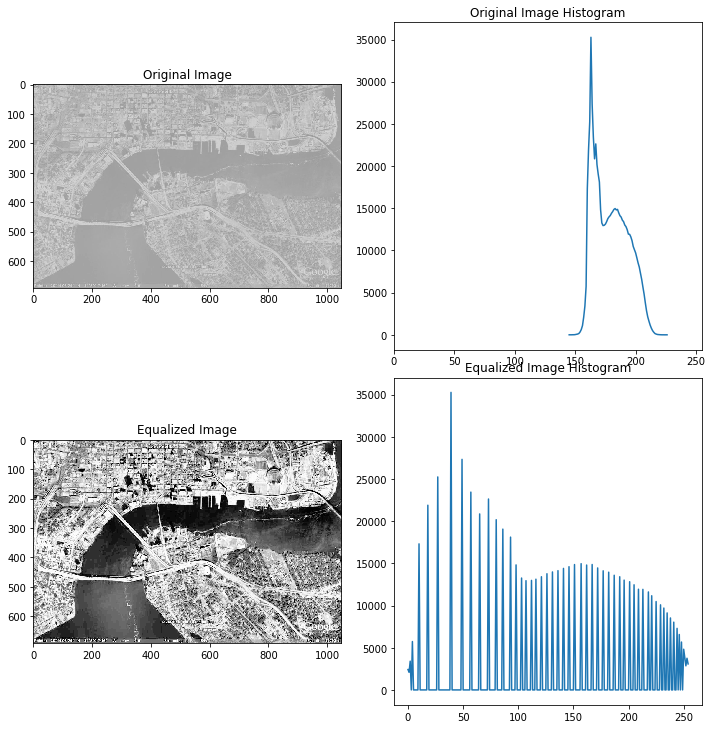

In [9]:
#Plot the original image, its histogram, the new image, and the new histogram
fig = plt.figure(figsize=(10, 10))

plt.subplot(221)
io.imshow(satellite_im)
plt.title("Original Image")

plt.subplot(222)
plt.plot(satellite_im_hist[1], satellite_im_hist[0])
plt.xlim((0,255))
plt.title("Original Image Histogram")

plt.subplot(223)
io.imshow(satellite_im_equ,cmap = cm.Greys_r)
plt.title("Equalized Image")

plt.subplot(224)
plt.plot(hist_satellite_im_equ[1], hist_satellite_im_equ[0])
plt.title("Equalized Image Histogram")


### Q.4 Histogram matching

** In this section we will perform histogram matching, the `hist_match` function is mostly defined here**
** `hist_match` uses the function that should define the Q.3 `hist_eq`, check the comments in the code as well **
 
** Explain the process of histogram matching in your own words**

Histogram matching is where an image and its histogram are transformed. The histogram for an image to be transformed to is a specified greylevel histogram, and therefore can be determined by the user. The process of histogram matching consists of histogram equalization followed by inverse histogram mapping, which produces the a final image which has the desired histogram. Sometimes, this is a normalized histogram, as used in the histogram equalization, which is a certain type of histogram matching. Othertimes, it is a gaussian histogram, as shown in the example below.

In [10]:
def find_inverse_mapping(mapping):
    # Initialise the inverse
    inv_mapping = np.zeros(mapping.shape)
    # Find the index that we can affect for sure
    idx_inv_map = np.unique(mapping)
    
    # For each index
    for idx in idx_inv_map:
        # Find the corresponding index value
        int_val = np.where(mapping == idx)[0][0]
        # Affect this value for the inverse mapping
        inv_mapping[idx] = int_val
        
    # Find the first index which is not zero
    first_elt_idx = np.nonzero(inv_mapping)[0][0]
    for i, elt in enumerate(inv_mapping[first_elt_idx:-1]):
        if (elt == 0):
            inv_mapping[i + first_elt_idx] = inv_mapping[i + first_elt_idx - 1]
        
    return inv_mapping.astype('uint8')



In [11]:
def hist_match(img, pdf_to_fit, min_int, max_int):
    # Equalize img
    
    ## hist_eq is actually the function that you should implement in the previous Question 
    img_eq, cdf_eq = hist_eq(img, min_int, max_int)
   
    
    # We need to make the matching now
    ## Compute the transform G
    
    ### Compute the cdf
    cdf = np.cumsum(pdf_to_fit)
    
    ### Multiply the cdf by the number of gray values
    cdf_real = cdf * float(max_int)
    ### Round the cdf
    G = np.floor(cdf_real).astype('int')
    
    ## But we need the inverse
    G_1 = find_inverse_mapping(G)
    
    img_match = np.zeros((img_eq.shape[0], img_eq.shape[1]))
    for i in range (np.shape(img_eq)[0]):
        for j in range (np.shape(img_eq)[1]):
            img_match[i][j] = G_1[int(img_eq[i][j])]
    
    return img_match.astype('ubyte')

**Creating a manual pdf following a gaussian distribution**

In [12]:
from scipy.stats import norm

max_img = 255

x = np.arange(max_img+1)
pdf_to_fit = norm.pdf(x, 150, 30)


**Use the defined function to match the histogram of gray version of satellite image to `pdf_to_fit`**

Text(0.5,1,'Matched Image Histogram')

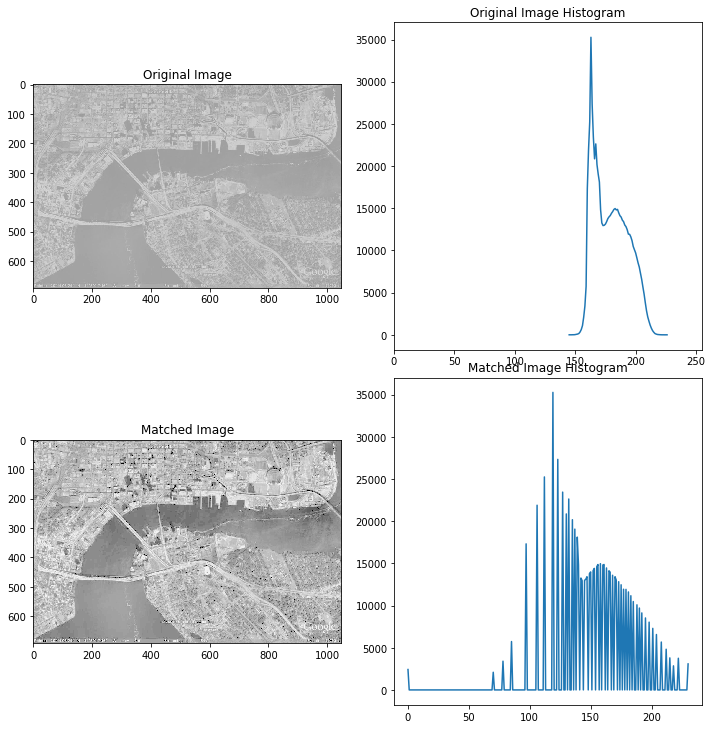

In [13]:
sat_im_fit = hist_match(satellite_im, pdf_to_fit, 0, 255)
hist_sat_im_fit = exposure.histogram(sat_im_fit)
fig = plt.figure(figsize=(10, 10))

plt.subplot(221)
io.imshow(satellite_im)
plt.title("Original Image")

plt.subplot(222)
plt.plot(satellite_im_hist[1], satellite_im_hist[0])
plt.xlim((0,255))
plt.title("Original Image Histogram")

plt.subplot(223)
io.imshow(sat_im_fit,cmap = cm.Greys_r)
plt.title("Matched Image")

plt.subplot(224)
plt.plot(hist_sat_im_fit[1], hist_sat_im_fit[0])
plt.title("Matched Image Histogram")


### Q.5 

** Explain the difference between log transform enhancement and gamma transform **


Log transform enhancement increases the contrast of low intensities, like how the log function looks (increasing quickly close to 0). The gamma transformation can either increase the contrast of low or high inensitites, depending on whether the value of gamma is positive or negative. The difference between log transform enhancement and gamma transformation enhancement lies in the fact that the log transform can only increase the contrast at low intensites, and the gamma transformation can increase it at high and low intensities.

** Explain how sigmoid function enhances the image **

The sigmoid function is shaped like an S. Therefore, the sigmoid transformation increases the intensity in the areas of an image with high intensity, and decreases in the intensity in the areas of an image with low intensity. This makes the light reigons lighter and the dark reigons darker, increasing the contrast. If the sigmoid function is shifted left or right, the image the tone of the image can be changed in a different way, such as by decreasing the amplitude of the sigmoid.